# Explicação da base de dados 

## Qual base que é?

Base de dados coletada do **Kaggle** do usuário Sobhan Moosavi em 2023. 

O dataset coletado possui informações sobre acidentes de carro que ocorreram em 49 estados dos EUA e foram coletados dentro do período de fevereiro de 2016 a março de 2023 utilizando diversas APIs que recolhem dados de acidentes de carro. Essas APIs são oferecidas e os dados são coletados por entidades dos EUA, incluindo a "US and state departments od transportation", agências de reforço de leis e câmeras e sensores de trafêgo dentro do sistema de estradas.

## Fonte?


Link da base do kaggle: https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents

Papers sobre a base de dados:
- Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. “A Countrywide Traffic Accident Dataset.”, 2019.
- Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. "Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights." In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019.

## O que tem na base?


A base contém diversas colunas que dizem respeito aos acidentes de carros identificados. As informações são divididas em 6 grupos diferentes, sendo eles:

**1) Identificação e origem:**
    - Possui um ID único e a fonte de onde veio a informação do acidente

**2) Detalhes do incidente**
    - Aqui temos a informação que será usada como variável resposta que é a *severidade* do acidente. Tem também horário que o acidente ocorreu

**3) Localização geográfica**
    - Informaçõees de onde o acidente ocorreu. As categorias desse grupo serão pouco utilizadas para o treinamento do modelo

**4) Condições climáticas**
    - Informações relevantes que indicam as condições do clima na hora do acidente. Apresenta dados de chuva, vento, pressão, visibilidade, etc.

**5) Condições da via**
    - Informações sobre o estado da via na hora do acidente. Se havia quebra-molas, placa de pare, trabessia de pedestres, rua sem saída, etc

**6) Condições de Luminosidade**
    - Apresenta como estava as condições de luz na hora do acidente, principalmente sobre a posição do Sol relativa ao período de crepúsculo náutico, civil e astronômico

# O que queremos

O **objetivo do trabalho** é **comparar a aplicação de uma técnica de machine learning e a utilização do framework Spark** pela API Pyspark em dois cenários diferentes, um, onde **as técnicas são aplicadas em todo o dataset** (neste caso, 7 milhões de linhas), e dois, onde as mesmas técnicas e abordagens são utilizadas no mesmo dataset, mas **agora com uma amostragem de 5000 linhas**.

A utilização do framework **Spark** neste trabalho tem o objetivo de **facilitar a carga, manipulação e tratamento de dados**, enquanto a utilização da **técnica de ML** tem por objetivo resolver um problema de **classificação**. 

- O problema a ser resolvido aqui visa **classificar corretamente a gravidade dos acidentes (Severity)** com base nas condições **climáticas**, nas condições da **via** e nas condições de **luminosidade** no momento do acidente.

# Importação de bibliotecas e Carregamento de dados

In [1]:
import time
import kagglehub

import pandas as pd
import pandasql as ps
from matplotlib import pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, hour, date_format

from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

/home/arthur/venv/trabalho-pyspark-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Início de uma seção do PySpark
spark = SparkSession.builder.appName('Traffic-Accidents').config("spark.driver.memory", "4g") \
                                                         .config("spark.executor.memory", "4g") \
                                                         .config("spark.executor.cores", "2") \
                                                         .config("spark.num.executors", "10") \
                                                         .getOrCreate()

# Download dos dados
# path = kagglehub.dataset_download("sobhanmoosavi/us-accidents")

# Leitura da base do kaggle
df = spark.read.csv('/home/arthur/.cache/kagglehub/datasets/sobhanmoosavi/us-accidents/versions/13/US_Accidents_March23.csv', header=True, inferSchema=True)

# Apresentação da tabela original
df.show()

25/01/28 07:49:48 WARN Utils: Your hostname, notebook resolves to a loopback address: 127.0.1.1; using 192.168.18.27 instead (on interface wlp2s0)
25/01/28 07:49:48 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/28 07:49:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/01/28 07:49:54 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/01/28 07:51:42 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----+-------+--------+-------------------+-------------------+------------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|  ID| Source|Severity|         Start_Time|           End_Time|         Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|A

## Descrição dos Dados

A base completa contém 46 colunas e mais de 7.7 Milhões de linhas.

In [3]:
print(f"Número de Linhas: {df.count()}")
print(f"Número de Colunas: {len(df.columns)}")

Número de Linhas: 7728394
Número de Colunas: 46


# Tratamento de Dados

## Valores Nulos

Identificamos a quantidade de NA's em cada coluna para verificar se seria necessário fazer o drop de algumas informações da base sem afetar a quantidade de informações que teríamos.

In [4]:
# Contando valores nulos
df_nulls = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])

# Transformando em um dataframe pandas
df_nulls_pandas = df_nulls.toPandas()

# Calculando o % da coluna que possui valores nulos
df_nulls_pandas_perc = 100* (df_nulls_pandas.T / df.count())

# Visualizando dados
df_nulls_pandas_perc.map('{:.2f}%'.format)

,0
ID,0.00%
Source,0.00%
Severity,0.00%
Start_Time,0.00%
End_Time,0.00%
Start_Lat,0.00%
Start_Lng,0.00%
End_Lat,44.03%
End_Lng,44.03%
Distance(mi),0.00%


Por fins de simplificação, após a identificação da quantidade percentual de NA's em cada coluna, decidimos por retirar todas as informações nulas de todas as categorias, com exceção das colunas:
- 'End_Lat';
- 'End_Lng';
- 'Wind_Chill(F)'; e
- 'Precipitation(in)'.

1) As informações de **'End_Lat'** e **'End_Lng'** não seriam utilizadas como parâmetros dentro do treinamento do modelo, por isso, optamos por mantê-las.

2) A informação de **"wind_chill"** e **"Precipitation"** foi mantida pois é possível aplicar alguma técnica de imputação de dados ao longo do projeto.

Após a limpeza dos dados nulos, ficamos com uma base com um pouco mais de 7 Milhões de linhas. perdendo menos de 10% da quantidade de informações do dataset original

In [5]:
# Colunas as quais não serão removidos os valores nulos
cols_to_save = ['End_Lat','End_Lng', 'Wind_Chill(F)', 'Precipitation(in)']

# Colunas que terão os valores nulos dropados
cols_to_drop = [c for c in df.columns if c not in cols_to_save ]

# Dropando NA's
df_cleaned_subset = df.dropna(subset=cols_to_drop)

# Visualizando dados, número de linhas e colunas
df_cleaned_subset.show()
print(f"Número de Linhas: {df_cleaned_subset.count()}")
print(f"Número de Colunas: {len(df_cleaned_subset.columns)}")

+----+-------+--------+-------------------+-------------------+------------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|  ID| Source|Severity|         Start_Time|           End_Time|         Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|A

Número de Linhas: 7051556
Número de Colunas: 46


# Featuring Engeneiring

Com base nas variáveis já existentes, criamos algumas variáveis como o dia da semana do acidente (day_of_week) e a hora do dia do acidente (hour_of_day)

In [6]:
# Extrai o dia da semana (em números)
df_cleaned_subset = df_cleaned_subset.withColumn("day_of_week", date_format(col("Start_Time"), "F").cast("int"))

# Extrai a hora do dia (em números)
df_cleaned_subset = df_cleaned_subset.withColumn("hour_of_day", hour(col("Start_Time")).cast("int"))

# Análise Exploratória

## Funções para auxiliar na visualização dos dados

In [7]:
def barplot(data, query, hue=False):

    data = ps.sqldf(query, locals())

    if hue:
        sns.barplot(data=data, x = data[data.columns[0]], y = data[data.columns[-1]], hue = data[data.columns[1]])
    else:
        sns.barplot(data=data, x = data[data.columns[0]], y = data[data.columns[-1]])

def histplot(data, query, hue=False, bins = None, rotation = None, figsize = None):

    data = ps.sqldf(query, locals())

    plt.figure(figsize = figsize)
    plt.xticks(rotation = rotation)

    if hue:
        return sns.histplot(data=data, x = data[data.columns[0]], hue = data[data.columns[1]], multiple = 'fill', bins = bins)
    else:
        return sns.histplot(data=data, x = data[data.columns[0]], bins = bins)
    
def plot_matrix(data, columns_features, n_rows, n_cols, plot, plot_kwargs = {}, loop_feature = None, figsize = (15,15), label = True):

    grid = gridspec.GridSpec(n_rows, n_cols)

    plt.figure(figsize=figsize)

    for r in range(0, n_rows):
        for c in range(0, n_cols ):
            if (c + r*n_cols) >= len(columns_features):
                break
            else:
                feature = columns_features[ (c + r*n_cols) ]

                if loop_feature:
                    plot_kwargs[loop_feature] = feature
                    
                plt.subplot(grid[r, c])
                plt.title(f'{feature}')
                g = plot(data = data, **plot_kwargs)

                if label:
                    for i in g.containers:
                        g.bar_label(i, color = 'black',label_type='edge')
                    else:
                        pass
            
    plt.tight_layout()

## Amostragem

A análise exploratória foi feita com somente uma amostra de 1% dos dados do dataset após tratamento (+-70.000 linhas)


In [8]:
# selecionando uma amostra de 1% do dataset para a visualização
sampled_df = df_cleaned_subset.sample(withReplacement=False, fraction=0.01)

# transformando dados em dataframe pandas
data_in_pandas = sampled_df.toPandas()

sampled_df.show()

+------+-------+--------+-------------------+-------------------+------------------+-------------------+-------+-------+------------+--------------------+--------------+--------------+------------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+-----------+-----------+
|    ID| Source|Severity|         Start_Time|           End_Time|         Start_Lat|          Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|        Street|          City|      County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitati

## Análise Univariada

### Variáveis Numéricas

O que foi percebido pelos gráficos:
1) As variáveis *Pressure*, *Visibility*, *Wind Speed*, *Precipitation* tinham outliers relevantes
2) *Temperature*: O total de acidentes sobe quanto maior a temperatura. A partir de 80 F (27°C) o total começa a cair
3) *Wind_Chill* (sensação térmica) segue um comportamento bem parecido à *Temperature*
4) *day_of_week*: os dias de segunda, terça e quarta feira são os dias com maior número de acidentes
5) *hour_of_day*: O intervalo das 7h-8h e 16-17h é o intervalo com maior número de acidades

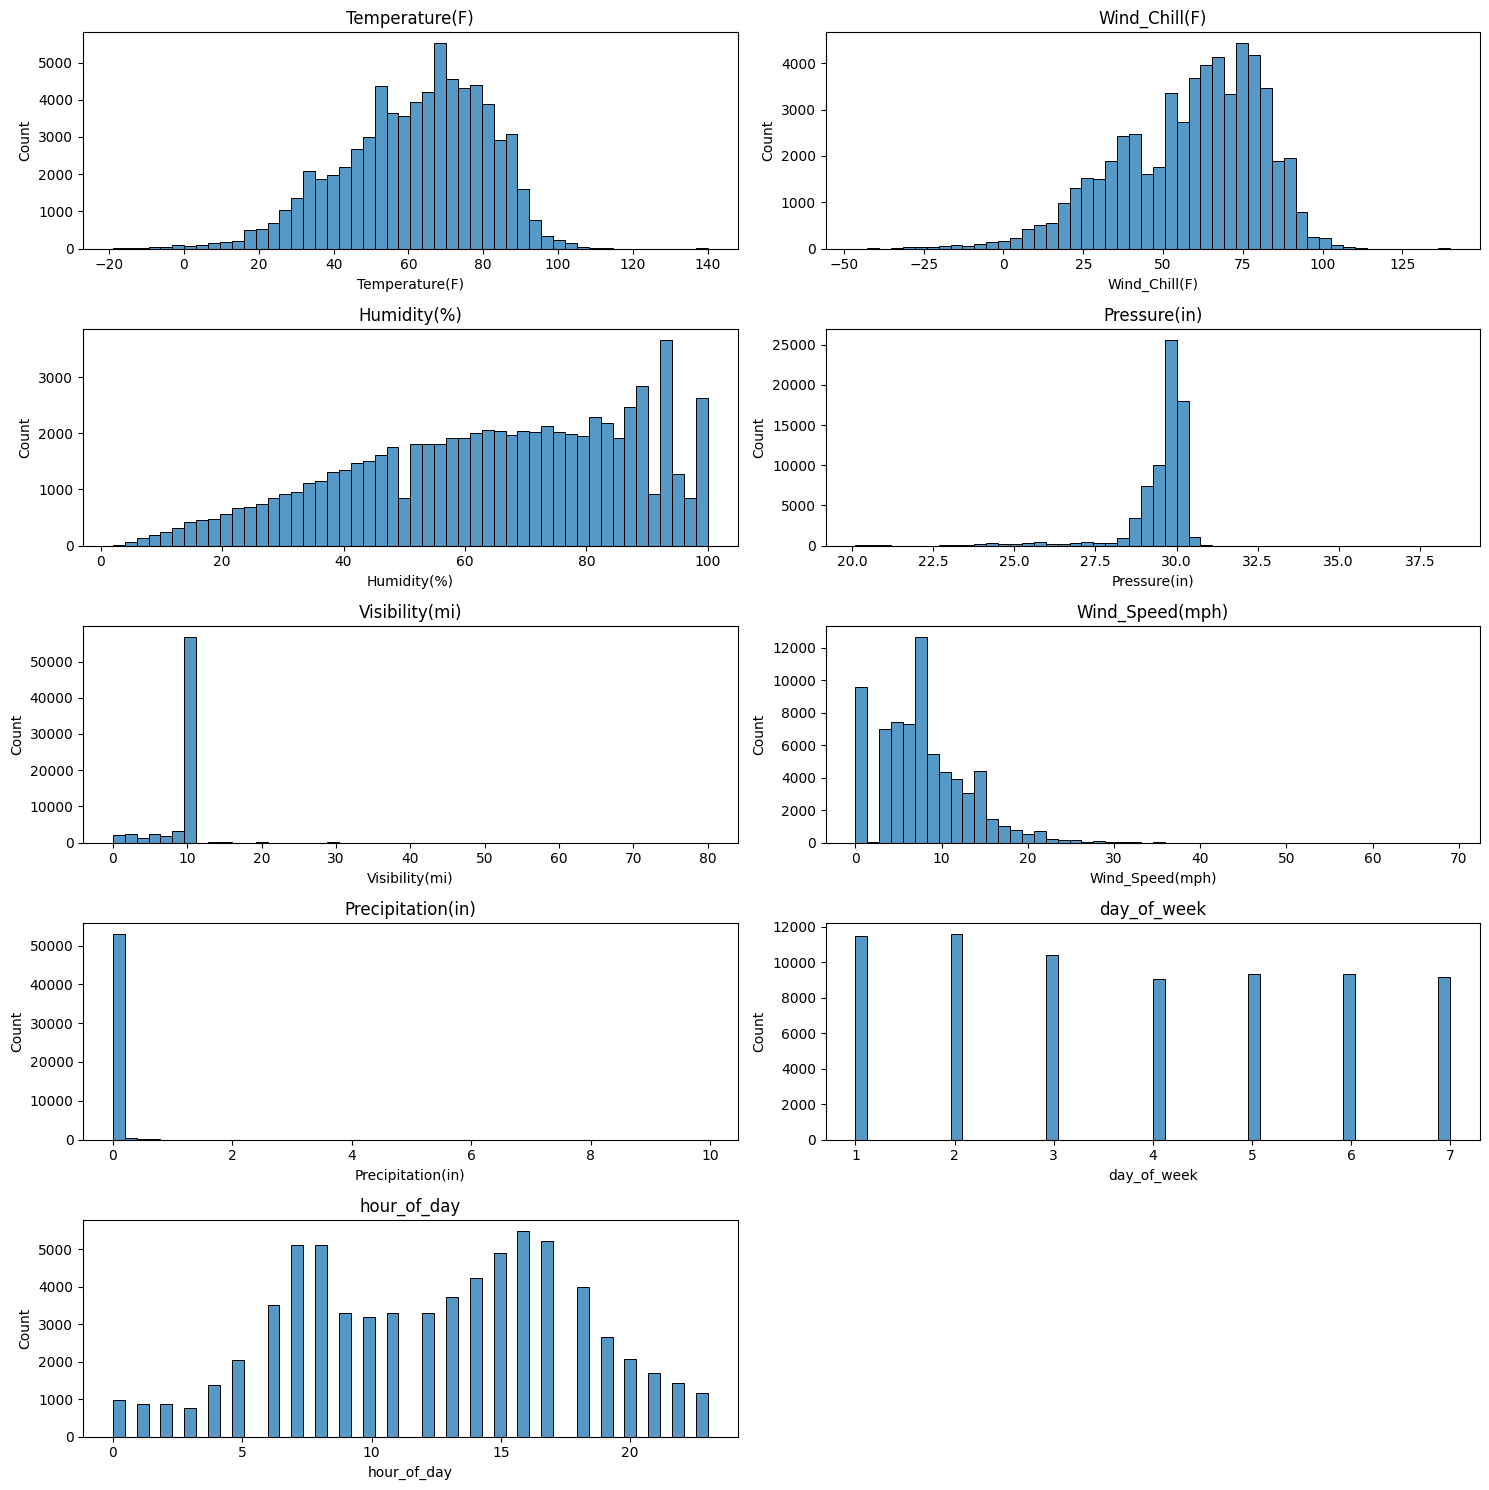

In [9]:
columns_features = ['Temperature(F)','Wind_Chill(F)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)', 'day_of_week', 'hour_of_day']
plot_matrix(data=data_in_pandas, columns_features=columns_features, n_rows = 5, n_cols = 2, plot = sns.histplot, plot_kwargs={'bins':50}, loop_feature = 'x' ,label=False)

### Variáveis Categóricas

Percepções:
1) Variável *turning_loop* não possui informação
2) Em todas as variáveis, a condição False predomina, e a análise bivariada é necessária para entender se são relevantes

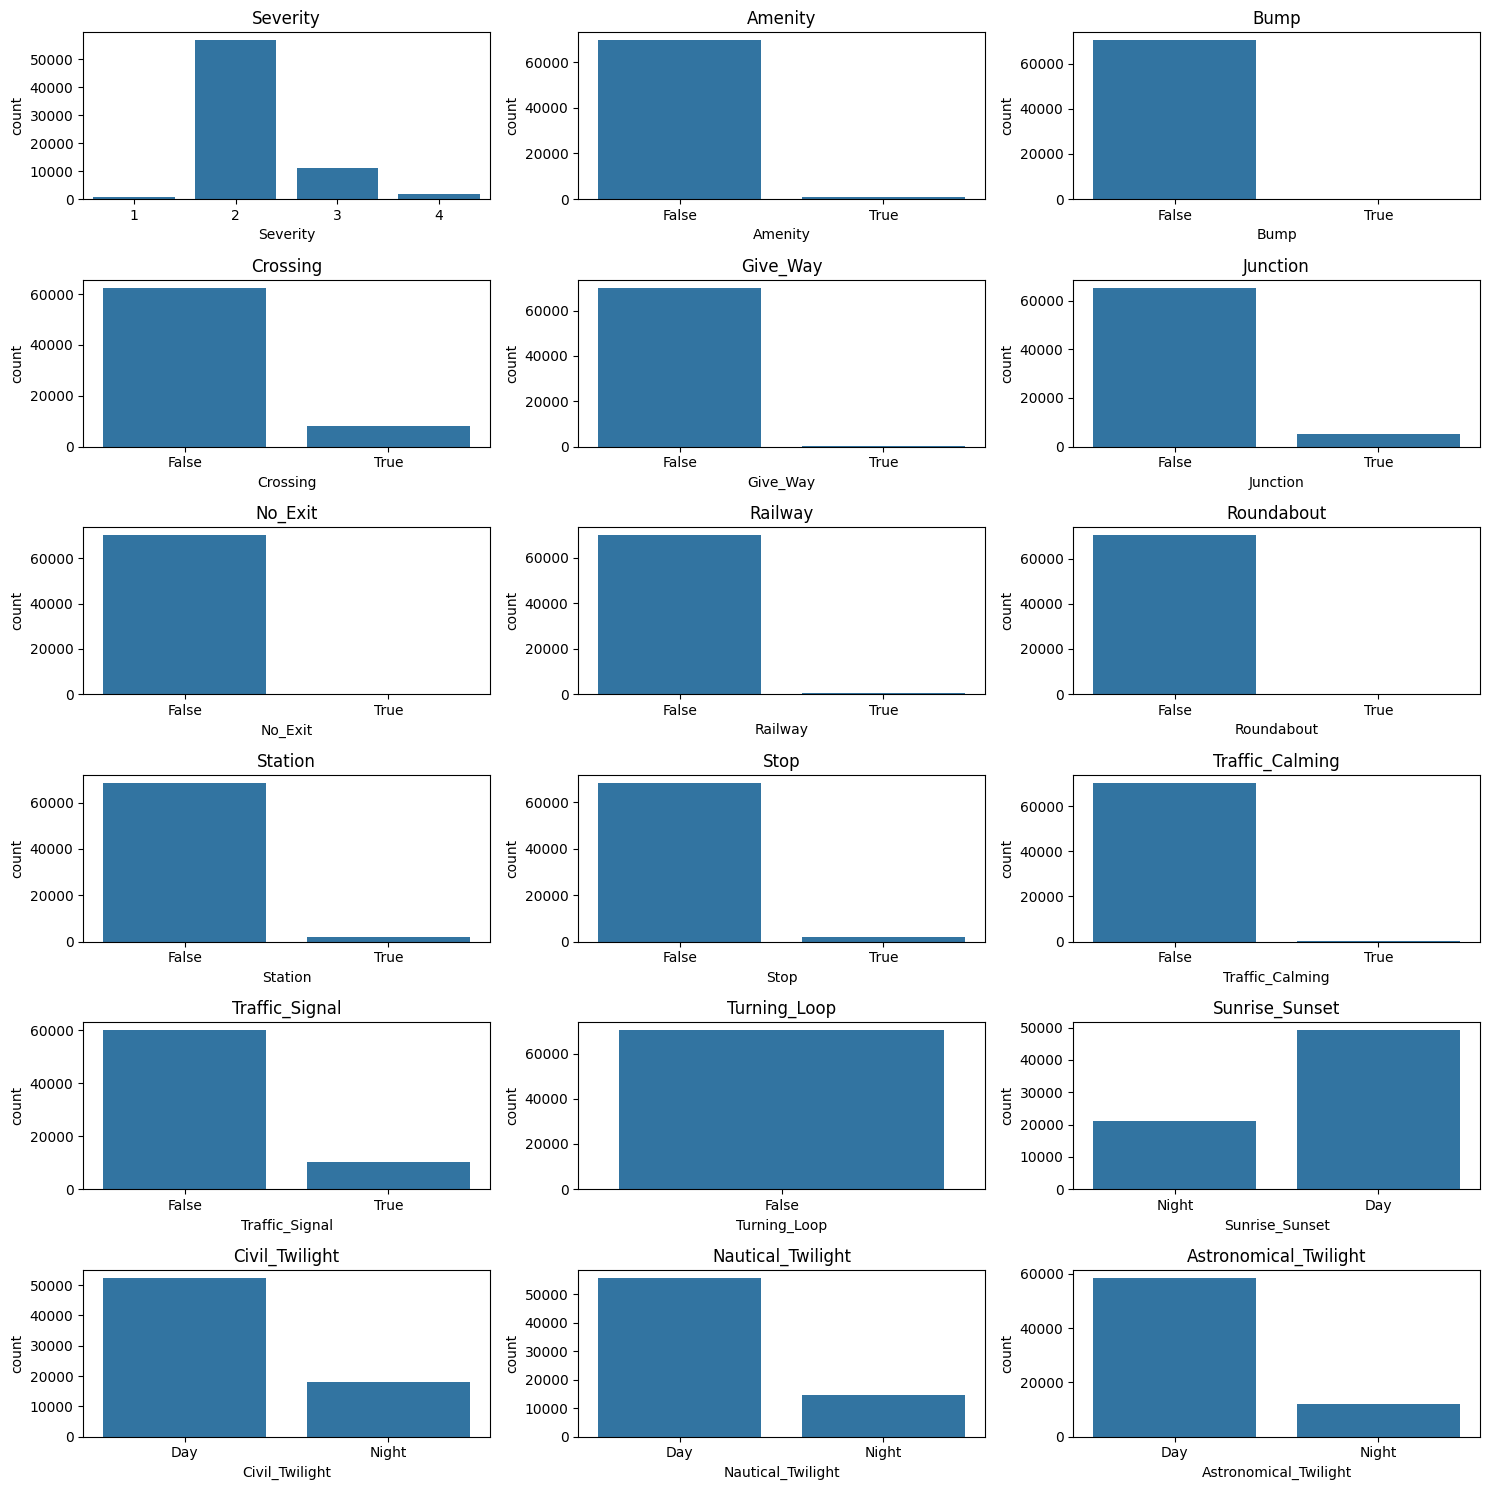

In [10]:
columns_features = ['Severity', 'Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station', 'Stop','Traffic_Calming','Traffic_Signal','Turning_Loop','Sunrise_Sunset','Civil_Twilight','Nautical_Twilight','Astronomical_Twilight']
plot_matrix(data=data_in_pandas, columns_features=columns_features, n_rows = 6, n_cols = 3, plot = sns.countplot, loop_feature = 'x' ,label=False)

## Análise Bivariada

### Variáveis Numéricas

Percepções
1) Acidentes em temperaturas mais baixas tendem à ter uma gravidade maior

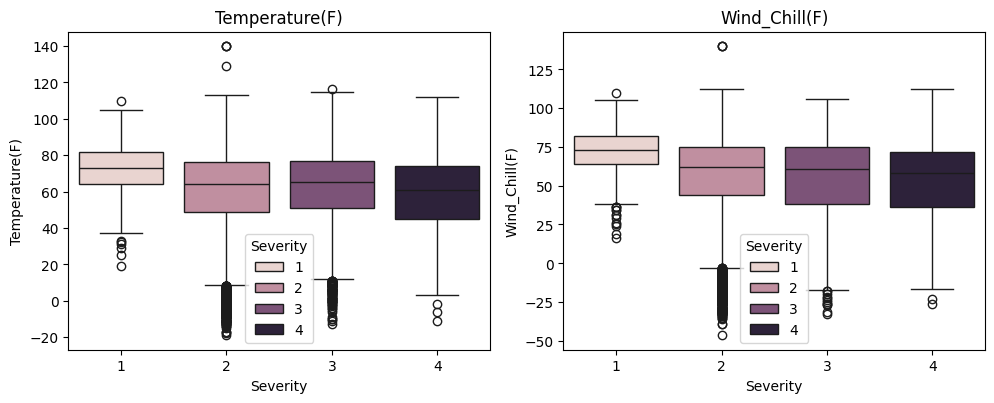

In [11]:
columns_features = ['Temperature(F)','Wind_Chill(F)']
plot_matrix(data=data_in_pandas, columns_features=columns_features, n_rows = 4, n_cols = 3, plot = sns.boxplot, plot_kwargs={'x': 'Severity', 'hue':'Severity'}, loop_feature = 'y' ,label=False)

### Variáveis Categóricas

Percepções
1) COLOCAR AS PERCEPÇÕES AQUI

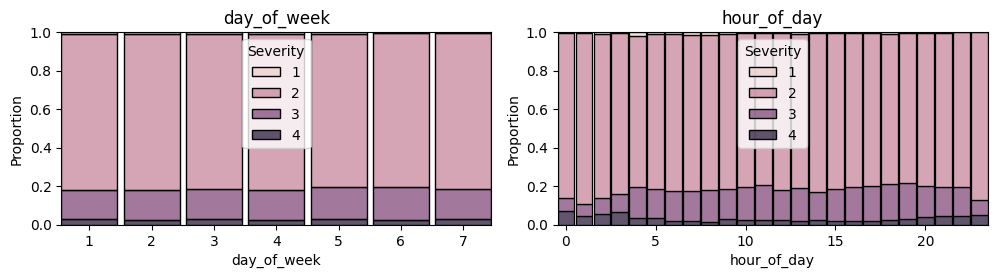

In [28]:
columns_features = ['day_of_week','hour_of_day']
plot_matrix(data=data_in_pandas, columns_features=columns_features, n_rows = 6, n_cols = 4, figsize=(20,15), plot = sns.histplot, plot_kwargs={'hue':'Severity', 'multiple':'fill','stat':'proportion', 'discrete':True, 'shrink':0.9}, loop_feature = 'x' ,label=False)

# Treinamento e avaliação para técnica de Random Forest

## Seleção das features relevantes

Para a simplificação do projeto, não foi realizada nenhuma técnica sofisticada para seleção de features.

Aqui, as features selecionadas foram todas as features relacionadas às condições da climáticas, da via e de luminosidade, com exceção de algumas que são expostas abaixo

In [13]:
selected_features = [
    # 'ID',               #---> identificador
    # 'Severity',         #---> variável resposta
    'Temperature(F)',
    'Humidity(%)',
    # 'Wind_Chill(F)',    #---> muitos NAs
    # 'Wind_Direction',   #---> variáveis com mtas categorias
    # 'Precipitation(in)',#---> muitos NAs
    'Pressure(in)',
    'Visibility(mi)',
    'Wind_Speed(mph)',
    'Amenity',
    'Bump',
    'Crossing',
    'Give_Way',
    'Junction',
    'No_Exit',
    'Railway',
    'Roundabout',
    'Station',
    'Stop',
    'Traffic_Calming',
    'Traffic_Signal',
    'Turning_Loop',
    'Sunrise_Sunset',
    'Civil_Twilight',
    'Nautical_Twilight',
    'Astronomical_Twilight',
    'day_of_week',
    'hour_of_day'
]

## Treinamento e avaliação para base completa

### Separação da Base

Para o treinamento do modelo, separamos a base em:
- 70% para treinamento (+4 Milhões de linhas)
- 30% para teste (+2.1 Milhões de linhas)

In [14]:
# Define as proporções para treino e teste
train_ratio = 0.7
test_ratio = 0.3

# Divide o dataset em treino e teste
train_data, test_data = df_cleaned_subset.randomSplit([train_ratio, test_ratio], seed=42)

print(f"Teste: Número de Colunas: {len(test_data.columns)}")
print(f"Treino: Número de Linhas: {train_data.count()}")
print(f"\nTeste: Número de Linhas: {test_data.count()}")

Teste: Número de Colunas: 48


Treino: Número de Linhas: 4936373



Teste: Número de Linhas: 2115183


### Tratamento dos dados de treino e de teste

#### **_*Standarization*_** e **_*Normalization*_**

Como o nosso objetivo aqui é fazer o teste quanto ao desempenho do modelo com a utilização do PySpark, nós optamos por manter o projeto o mais simples possível e por isso não realizamos o processo de ajustes de escalas do modelo. 

Outro motivo de optarmos por não realizar esses procedimentos é por utilizarmos a técnica de 'random forest' e este não se altera com categorias que estejam fora de escala.

### Treino

#### **_*Encoding*_**

Apesar de não fazermos o processo de standarization e normalization, realizamos o encoding de algumas colunas do dataset para garantir que tudo esteja dentro do padrão aceitado pelo modelo

##### Boolenas
Tratamento das colunas especificadas para garantir que são de fato valores do tipo int

In [15]:
bool_columns_to_transform = [
  'Amenity',
  'Bump',
  'Crossing',
  'Give_Way',
  'Junction',
  'No_Exit',
  'Railway',
  'Roundabout',
  'Station',
  'Stop',
  'Traffic_Calming',
  'Traffic_Signal',
  'Turning_Loop'
]

for column in bool_columns_to_transform:
    train_data = train_data.withColumn(
      column, col(column).cast("int")
    )

##### Categóricas
Tratamento das colunas especificadas para garantir que são de fato valores do tipo int transformar para os seguintes valores:
- Day = 1
- Night = 0

In [16]:
cat_columns_to_transform = [
    'Sunrise_Sunset',
    'Civil_Twilight',
    'Nautical_Twilight',
    'Astronomical_Twilight'
]

for column in cat_columns_to_transform:
    train_data = train_data.withColumn(
        column, when(col(column) == 'Day', 1).otherwise(0)
    )


### Teste

#### **_*Encoding*_**

Fizemos o mesmo procedimento para os dados de teste do modelo

##### Boolenas
Tratamento das colunas especificadas para garantir que são de fato valores do tipo int

In [17]:
bool_columns_to_transform = [ 
  'Amenity',
  'Bump',
  'Crossing',
  'Give_Way',
  'Junction',
  'No_Exit',
  'Railway',
  'Roundabout',
  'Station',
  'Stop',
  'Traffic_Calming',
  'Traffic_Signal',
  'Turning_Loop'
]

for column in bool_columns_to_transform:
    test_data = test_data.withColumn(
      column, col(column).cast("int")
    )

##### Categóricas
Tratamento das colunas especificadas para garantir que são de fato valores do tipo int transformar para os seguintes valores:
- Day = 1
- Night = 0

In [18]:
cat_columns_to_transform = [
'Sunrise_Sunset',
'Civil_Twilight',
'Nautical_Twilight',
'Astronomical_Twilight'
]

for column in cat_columns_to_transform:
    test_data = test_data.withColumn(
        column, when(col(column) == 'Day', 1).otherwise(0)
    )

### Treinamento e avaliação

Para o processo de treinamento e validação do modelo, criamos inicalmente um DataFrame vazio para armazenar os resultados das métricas que serão calculadas. Em seguida, ocorre a etapa de preparação dos dados, onde as colunas selecionadas são unificadas em uma única coluna chamada "features". Essa transformação organiza os dados de entrada no formato necessário para o modelo. Além disso, uma coluna categórica, que representa os rótulos de classificação, é convertida em números para facilitar o processamento.

Na sequência, são definidos avaliadores responsáveis por medir o desempenho do modelo.As métricas utilziadas são:
1) precisão;
2) recall;
3) acurácia; e
4) F1-Score,
5) tempo de execução do processo

In [19]:
# salvar resultados
df_results = pd.DataFrame()

# Pré-processamento
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
label_indexer = StringIndexer(inputCol="Severity", outputCol="indexedLabel")

# Avaliador
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1")

time_start = time.time()
# definindo modelo
model_name = "Random Forest"
model = RandomForestClassifier(featuresCol="features", labelCol="indexedLabel")

# Criando pipeline
pipeline = Pipeline(stages=[assembler, label_indexer, model])

# Treinamento
model_pipeline = pipeline.fit(train_data)

# Teste
predictions = model_pipeline.transform(test_data)

# # Avaliação
accuracy = evaluator_accuracy.evaluate(predictions)
precision = evaluator_precision.evaluate(predictions)
recall = evaluator_recall.evaluate(predictions)
f1 = evaluator_f1.evaluate(predictions)

df_results_aux = pd.DataFrame(
    {
        'Model Name': model_name,
        'Accuracy':accuracy,
        'Precision':precision,
        'Recall':recall,
        'F1-Score':f1,
     },
     index=[0]
)

df_results = pd.concat([df_results, df_results_aux], axis = 0 )

time_end = time.time()

execution_time = time_end - time_start

df_results

25/01/28 08:08:18 WARN MemoryStore: Not enough space to cache rdd_97_12 in memory! (computed 28.8 MiB so far)
25/01/28 08:08:18 WARN BlockManager: Persisting block rdd_97_12 to disk instead.
25/01/28 08:08:18 WARN MemoryStore: Not enough space to cache rdd_97_10 in memory! (computed 28.8 MiB so far)
25/01/28 08:08:18 WARN BlockManager: Persisting block rdd_97_10 to disk instead.
25/01/28 08:08:18 WARN MemoryStore: Not enough space to cache rdd_97_13 in memory! (computed 28.8 MiB so far)
25/01/28 08:08:18 WARN BlockManager: Persisting block rdd_97_13 to disk instead.
25/01/28 08:08:19 WARN MemoryStore: Not enough space to cache rdd_97_9 in memory! (computed 28.8 MiB so far)
25/01/28 08:08:19 WARN BlockManager: Persisting block rdd_97_9 to disk instead.
25/01/28 08:08:19 WARN MemoryStore: Not enough space to cache rdd_97_8 in memory! (computed 28.8 MiB so far)
25/01/28 08:08:19 WARN BlockManager: Persisting block rdd_97_8 to disk instead.
25/01/28 08:08:19 WARN MemoryStore: Not enough sp

,Model Name,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.804417,0.647087,0.804417,0.717226


## Treinamento e avaliação para Amostra de 5000 linhas

Todos os processos descritos acima foram replicados para uma amostragem de 5 mil linhas do dataset.

### Separação de 5.000 linhas da amostragem

In [20]:
fraction = 5000 / df.count()

# Amostra aleatória
sampled_df = df_cleaned_subset.sample(withReplacement=False, fraction=fraction, seed=42)

### Separação da Base

In [21]:
# Define as proporções para treino e teste
train_ratio = 0.7
test_ratio = 0.3

# Divide o dataset em treino e teste
train_data_sampled, test_data_sampled = sampled_df.randomSplit([train_ratio, test_ratio], seed=42)

print(f"Treino: Número de Colunas: {len(train_data_sampled.columns)}")
print(f"Treino: Número de Linhas: {train_data_sampled.count()}")
print(f"\nTeste: Número de Linhas: {test_data_sampled.count()}")

Treino: Número de Colunas: 48


Treino: Número de Linhas: 3182



Teste: Número de Linhas: 1397


### Encoding de booleanas e categóricas para base de treino

In [22]:
bool_columns_to_transform = [ 
 'Amenity',
 'Bump',
 'Crossing',
 'Give_Way',
 'Junction',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Traffic_Signal',
 'Turning_Loop'
]

for column in bool_columns_to_transform:
    train_data_sampled = train_data_sampled.withColumn(
      column, col(column).cast("int")
    )
  
cat_columns_to_transform = [
'Sunrise_Sunset',
'Civil_Twilight',
'Nautical_Twilight',
'Astronomical_Twilight'
]

for column in cat_columns_to_transform:
    train_data_sampled = train_data_sampled.withColumn(
        column, when(col(column) == 'Day', 1).otherwise(0)
    )


### Encoding de booleanas e categóricas para base de teste

In [23]:
bool_columns_to_transform = [ 
 'Amenity',
 'Bump',
 'Crossing',
 'Give_Way',
 'Junction',
 'No_Exit',
 'Railway',
 'Roundabout',
 'Station',
 'Stop',
 'Traffic_Calming',
 'Traffic_Signal',
 'Turning_Loop'
]

for column in bool_columns_to_transform:
    test_data_sampled = test_data_sampled.withColumn(
      column, col(column).cast("int")
    )

cat_columns_to_transform = [
'Sunrise_Sunset',
'Civil_Twilight',
'Nautical_Twilight',
'Astronomical_Twilight'
]

for column in cat_columns_to_transform:
    test_data_sampled = test_data_sampled.withColumn(
        column, when(col(column) == 'Day', 1).otherwise(0)
    )

### Treinamento e Avaliação do modelo

In [24]:
# salvar resultados
df_results_sampled = pd.DataFrame()

# Pré-processamento
assembler = VectorAssembler(inputCols=selected_features, outputCol="features")
label_indexer = StringIndexer(inputCol="Severity", outputCol="indexedLabel")

# Avaliador
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="indexedLabel", predictionCol="prediction", metricName="f1")

time_start_sample = time.time()
# definindo modelo
model_name = "Random Forest"
model = RandomForestClassifier(featuresCol="features", labelCol="indexedLabel")

# Criando pipeline
pipeline = Pipeline(stages=[assembler, label_indexer, model])

# Treinamento
model_pipeline = pipeline.fit(train_data_sampled)

# Teste
predictions_sampled = model_pipeline.transform(test_data_sampled)

# # Avaliação
accuracy = evaluator_accuracy.evaluate(predictions_sampled)
precision = evaluator_precision.evaluate(predictions_sampled)
recall = evaluator_recall.evaluate(predictions_sampled)
f1 = evaluator_f1.evaluate(predictions_sampled)

df_results_sampled_aux = pd.DataFrame(
    {
        'Model Name': model_name,
        'Accuracy':accuracy,
        'Precision':precision,
        'Recall':recall,
        'F1-Score':f1,
     },
     index=[0]
)

time_end_sample = time.time()
execution_time_sample = time_end_sample - time_start_sample

df_results_sampled = pd.concat([df_results_sampled, df_results_sampled_aux], axis = 0 )

df_results_sampled

,Model Name,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.816034,0.665912,0.816034,0.733369


# Comparação dos resultados obtidos

O treinamento do modelo de random forest e utilizando a base completa gerou como resultados:
- Accuracy: 0.804
- Precision: 0.647
- Recall: 0.804
- F1-Score: 0.717

In [25]:
# Base de dados completa
df_results

,Model Name,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.804417,0.647087,0.804417,0.717226


O treinamento do modelo de random forest e utilizando a base amostral de 5 mil linhas gerou como resultados:
- Accuracy: 0.816
- Precision: 0.665
- Recall: 0.816
- F1-Score: 0.733

In [26]:
# amostra de 5000 linhas
df_results_sampled

,Model Name,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.816034,0.665912,0.816034,0.733369


In [27]:
print(f'Tempo de execução base completa: {execution_time/60:.2f} minutos')
print(f'Tempo de execução amostra de 5000 linhas: {execution_time_sample/60:.2f} minutos')

Tempo de execução base completa: 16.94 minutos
Tempo de execução amostra de 5000 linhas: 10.33 minutos


# Conclusão

Sobre a comparação dos resultados do ML:

- Os resultados do modelo utilizando a amostragem de 5k se mostraram bem semelhantes aos resultados do modelo que utilizou a base completa. 
- Como foi utilizada uma amostragem aleatória simples para a amostragem da base, espera-se que ela siga o mesmo comportamento da base completa, e consequentemente que o ML consiga encontrar os mesmos padrões na base amostrada.
- Apesar disso, espera-se que o erro associado à base amostrada seja maior que com a base completa. Isso poderia ser evidenciado aplicando-se um cross validation durante o treinamento e validação da base

Sobre a comparação dos tempos de processamento:
- Apesar da grande diferença de tamanho dos datasets, de 7 milhões para 5000 linhas (0,07% da base total), o tempo de processamento foi relativamente próximo, de 16 min para 10 min (60% do tempo com a base total)
- Um dos principais motivos pelo qual isso pode ter ocorrido é devido ao que podemos chamar de **"overhead"** de operações no Pyspark
- Independente do tamanho do dataset, o Pyspark precisa realizar operações de transformação, otimização, particionamento, distribuição e paralelização dos executores que são inerantes ao processo. Dessa forma independente do tamanho do dataset, alguma parte do tempo já estaria ocupada com essa operações e apenas a outra parcela do tempo, ocupada com o processamento dos dados em si.
